# Analyse des activations

Ce notebook sert à analyser un dataset d'activation de neuronnes

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pickle import load
from classif_model import GlobalConfig, DataProcessor, unpack_attentions
from nn_viz import DrawNN
import torch

c:\Users\andre\Documents\Cours\SSD\M2\ProjetM2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing

In [2]:
with open("logging/gpt2/gpt2_res.pkl", "rb") as file:
    data_gpt2 = load(file)
with open("logging/gpt2_L1_08_res.pkl/gpt2_L1_08_res.pkl_res.pkl", "rb") as file:
    data_gpt2_L1_08 = load(file)

# Activations

## Normal model

Unbatching the data from the attention heads

In [4]:
fun_data_layer1 = [obs["Dropout2"].tolist() for obs in np.array(data_gpt2["classif_activations"])[np.array(data_gpt2["predictions"]) == 0]]
unfun_data_layer1 = [obs["Dropout2"].tolist() for obs in np.array(data_gpt2["classif_activations"])[np.array(data_gpt2["predictions"]) == 1]]
fun_data_layer2 = [obs["Dropout5"].tolist() for obs in np.array(data_gpt2["classif_activations"])[np.array(data_gpt2["predictions"]) == 0]]
unfun_data_layer2 = [obs["Dropout5"].tolist() for obs in np.array(data_gpt2["classif_activations"])[np.array(data_gpt2["predictions"]) == 1]]

<Axes: >

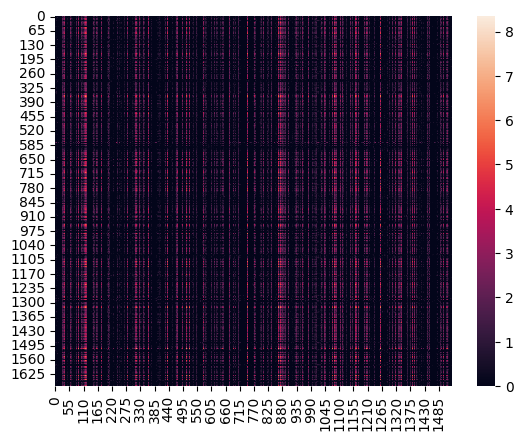

In [5]:
sns.heatmap(fun_data_layer1)

<Axes: >

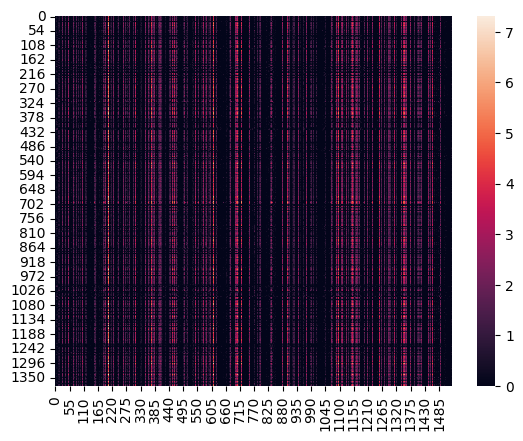

In [6]:
sns.heatmap(unfun_data_layer1)

<Axes: >

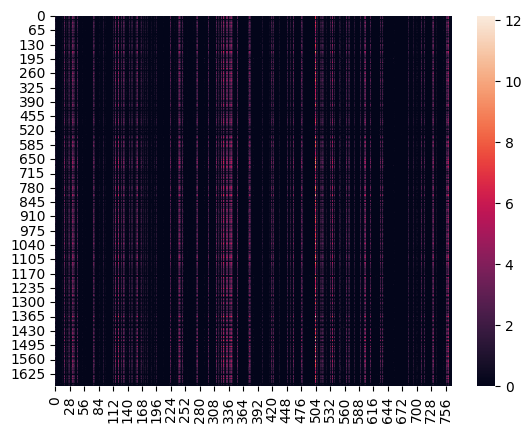

In [7]:
sns.heatmap(fun_data_layer2)

<Axes: >

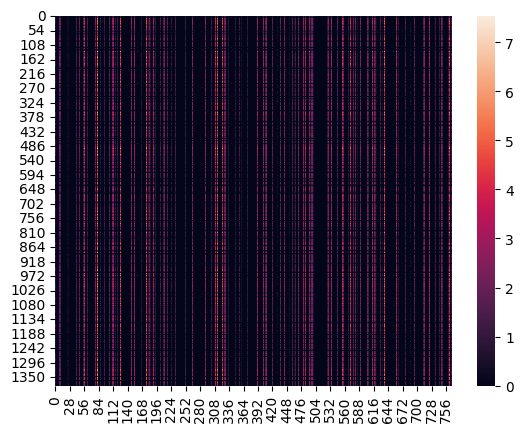

In [8]:
sns.heatmap(unfun_data_layer2)

## Extracting mean activations for each layer and each prediction

In [9]:

layer1_fun = torch.zeros((data_gpt2["classif_activations"][0]["Dropout2"].shape))
layer2_fun = torch.zeros((data_gpt2["classif_activations"][0]["Dropout5"].shape))
layer1_unfun = torch.zeros((data_gpt2["classif_activations"][0]["Dropout2"].shape))
layer2_unfun = torch.zeros((data_gpt2["classif_activations"][0]["Dropout5"].shape))
nb_unfuned = sum(data_gpt2["predictions"])
nb_fun = len(data_gpt2["predictions"]) - nb_unfuned
for obs_idx in range(len(data_gpt2["classif_activations"])):
    if data_gpt2["predictions"][obs_idx] == 0:
        layer1_fun += data_gpt2["classif_activations"][obs_idx]["Dropout2"]
        layer2_fun += data_gpt2["classif_activations"][obs_idx]["Dropout5"]
    else:
        layer1_unfun += data_gpt2["classif_activations"][obs_idx]["Dropout2"]
        layer2_unfun += data_gpt2["classif_activations"][obs_idx]["Dropout5"]
layer1_fun /= nb_fun
layer2_fun /= nb_fun
layer1_unfun /= nb_unfuned
layer2_unfun /= nb_unfuned

<Axes: >

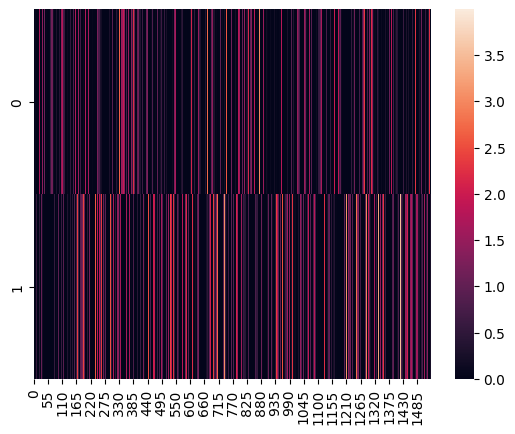

In [11]:
sns.heatmap([layer1_fun.numpy(),
             layer1_unfun.numpy()])

<Axes: >

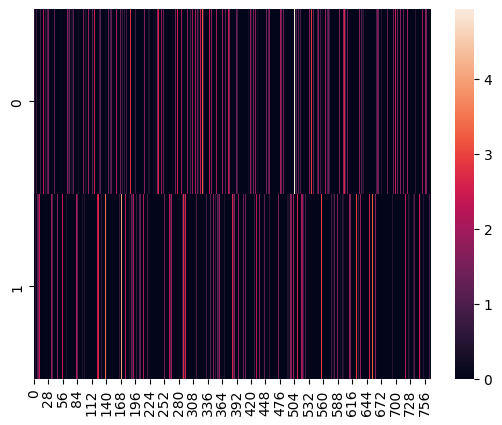

In [12]:
sns.heatmap([layer2_fun.numpy(),
             layer2_unfun.numpy()])

## Analyse en composante principale

In [16]:
def plot_acp(data, labels):
    # on commence par normaliser les données 
    data_normalized = StandardScaler().fit_transform(data)

    # ensuite on effectue l'ACP avec 2 composantes
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_normalized)

    # transforme les résultats en dataframe 
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Number'] = labels

    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Number',
        palette='tab10',  # Palette de 10 couleurs
        data=pca_df,
        s=10, alpha=0.6  # Réduire la taille des points pour plus de clarté
    )
    plt.show()

In [15]:
activations_layer1 = [obs["Dropout2"].tolist() for obs in np.array(data_gpt2["classif_activations"])]
activations_layer2 = [obs["Dropout5"].tolist() for obs in np.array(data_gpt2["classif_activations"])]

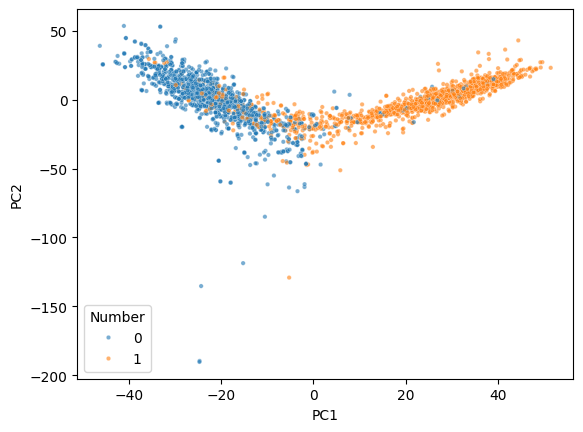

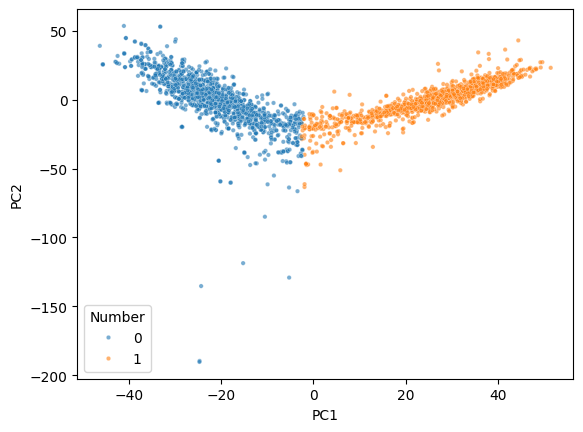

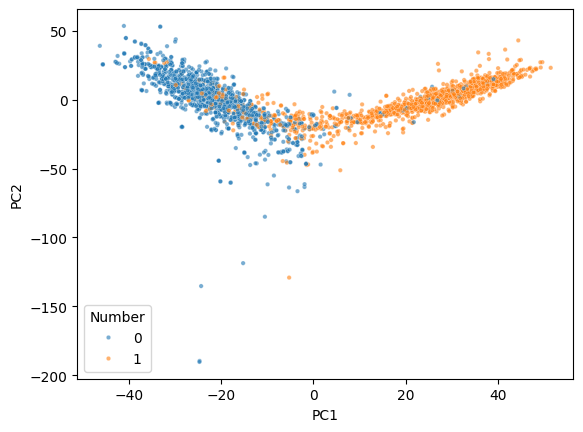

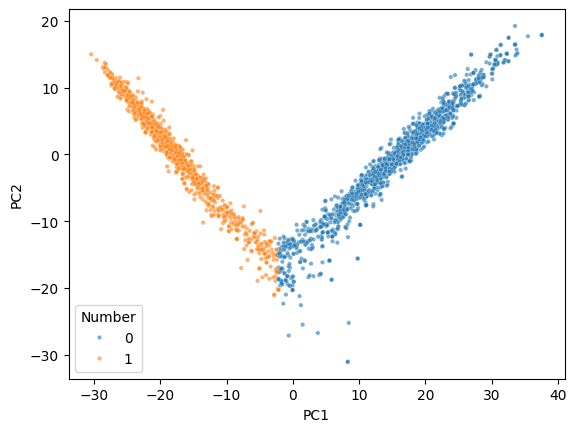

In [17]:
plot_acp(pd.DataFrame(activations_layer1), data_gpt2["targets"])
plot_acp(pd.DataFrame(activations_layer1), data_gpt2["predictions"])
plot_acp(pd.DataFrame(activations_layer1), data_gpt2["targets"])
plot_acp(pd.DataFrame(activations_layer2), data_gpt2["predictions"])

In [18]:
activations_all = [0] * len(activations_layer1)
for idx in range(len(activations_layer1)):
    activations_all[idx] = activations_layer1
    #print(activations_all[idx])
    activations_all[idx].extend(activations_layer2)

In [ ]:
X = activations_all
y = data_gpt2["targets"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [7]:
X = activations_all
y = data_gpt2["targets"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softmax",  # Problème de classification multiclasses
    "num_class": 10,               # Nombre de classes
    "max_depth": 4,               # Profondeur maximale des arbres
    "eta": 0.3,                   # Taux d'apprentissage (learning rate)
    "eval_metric": "mlogloss"     # Log-loss pour évaluer le modèle
}

num_round = 50
bst = xgb.train(params, dtrain, num_round)

preds = bst.predict(dtest)

accuracy = accuracy_score(y_test, preds)
print(f"Précision du modèle : {accuracy:.2f}")

Précision du modèle : 0.98


## L1 regularisation

In [3]:
attentions_gpt2L1 = unpack_attentions(data_gpt2_L1_08["attentions"])

In [6]:
layer1_L1_fun = torch.zeros((data_gpt2_L1_08["classif_activations"][0]["Dropout2"].shape))
layer2_L1_fun = torch.zeros((data_gpt2_L1_08["classif_activations"][0]["Dropout5"].shape))
layer1_L1_unfun = torch.zeros((data_gpt2_L1_08["classif_activations"][0]["Dropout2"].shape))
layer2_L1_unfun = torch.zeros((data_gpt2_L1_08["classif_activations"][0]["Dropout5"].shape))
nb_L1_unfuned = sum(data_gpt2_L1_08["predictions"])
nb_L1_fun = len(data_gpt2_L1_08["predictions"]) - nb_L1_unfuned
for obs_idx in range(len(data_gpt2_L1_08["classif_activations"])):
    if data_gpt2_L1_08["predictions"][obs_idx] == 0:
        layer1_L1_fun += data_gpt2_L1_08["classif_activations"][obs_idx]["Dropout2"]
        layer2_L1_fun += data_gpt2_L1_08["classif_activations"][obs_idx]["Dropout5"]
    else:
        layer1_L1_unfun += data_gpt2_L1_08["classif_activations"][obs_idx]["Dropout2"]
        layer2_L1_unfun += data_gpt2_L1_08["classif_activations"][obs_idx]["Dropout5"]
layer1_L1_fun /= nb_L1_fun
layer2_L1_fun /= nb_L1_fun
layer1_L1_unfun /= nb_L1_unfuned
layer2_L1_unfun /= nb_L1_unfuned

<Axes: >

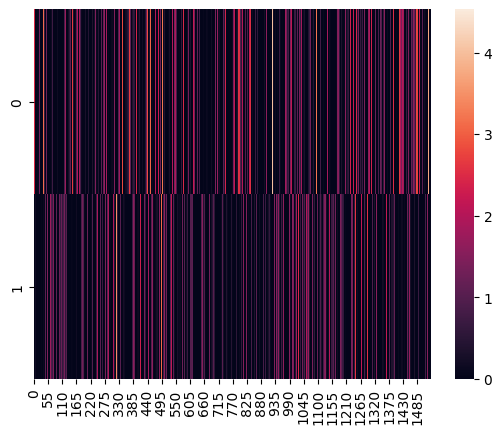

In [7]:
sns.heatmap([layer1_L1_fun.numpy(),
             layer1_L1_unfun.numpy()])

<Axes: >

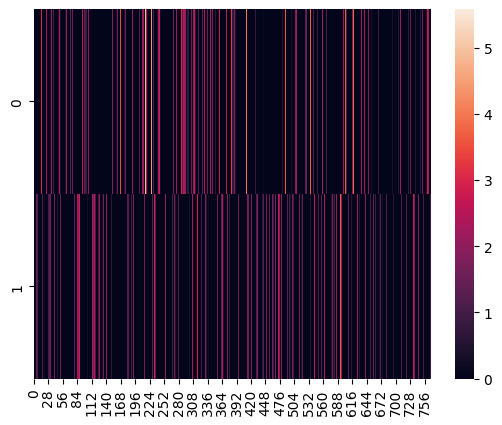

In [8]:
sns.heatmap([layer2_L1_fun.numpy(),
             layer2_L1_unfun.numpy()])

In [9]:
fun_dataL1_layer1 = [obs["Dropout2"].tolist() for obs in np.array(data_gpt2_L1_08["classif_activations"])[np.array(data_gpt2_L1_08["predictions"]) == 0]]
unfun_dataL1_layer1 = [obs["Dropout2"].tolist() for obs in np.array(data_gpt2_L1_08["classif_activations"])[np.array(data_gpt2_L1_08["predictions"]) == 1]]
fun_dataL1_layer2 = [obs["Dropout5"].tolist() for obs in np.array(data_gpt2_L1_08["classif_activations"])[np.array(data_gpt2_L1_08["predictions"]) == 0]]
unfun_dataL1_layer2 = [obs["Dropout5"].tolist() for obs in np.array(data_gpt2_L1_08["classif_activations"])[np.array(data_gpt2_L1_08["predictions"]) == 1]]

<Axes: >

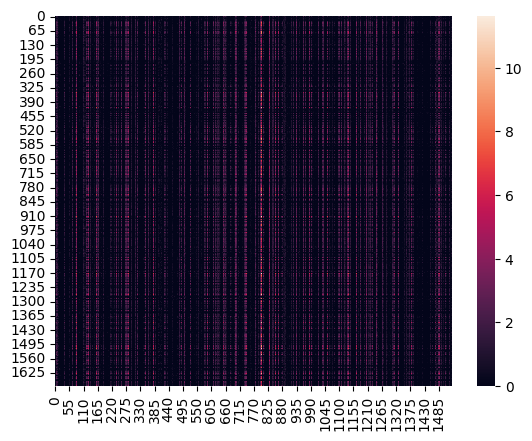

In [10]:
sns.heatmap(fun_dataL1_layer1)

<Axes: >

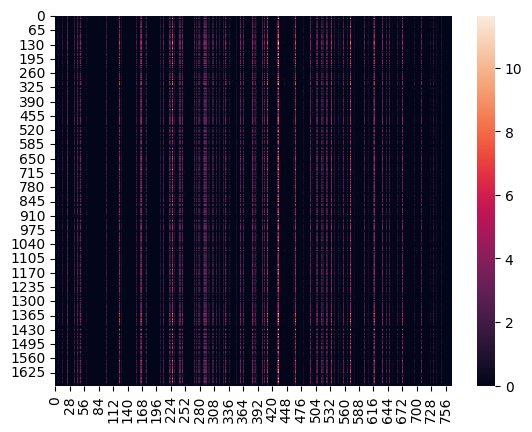

In [11]:
sns.heatmap(fun_dataL1_layer2)

<Axes: >

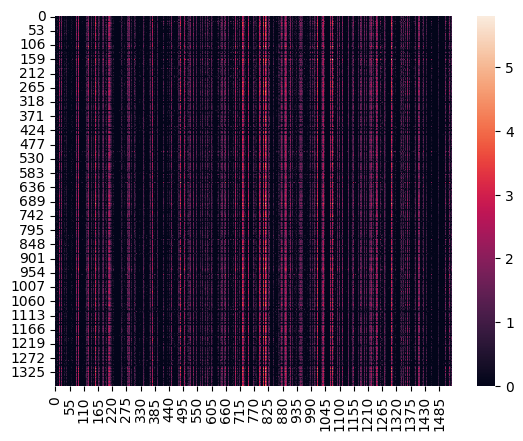

In [12]:
sns.heatmap(unfun_dataL1_layer1)

<Axes: >

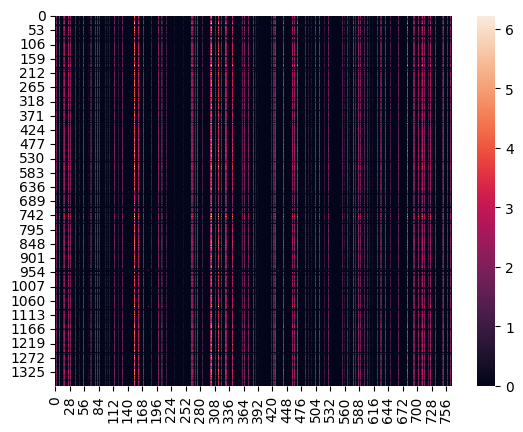

In [14]:
sns.heatmap(unfun_dataL1_layer2)

In [18]:
activations_L1_layer1 = [obs["Dropout2"].tolist() for obs in np.array(data_gpt2_L1_08["classif_activations"])]
activations_L1_layer2 = [obs["Dropout5"].tolist() for obs in np.array(data_gpt2_L1_08["classif_activations"])]

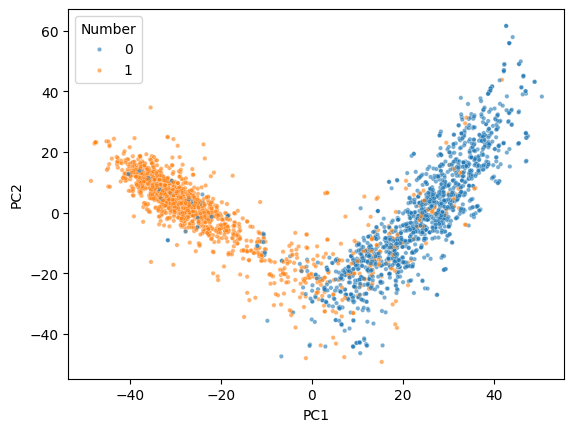

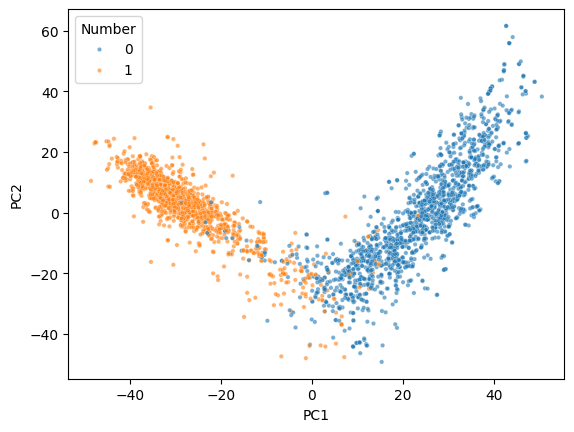

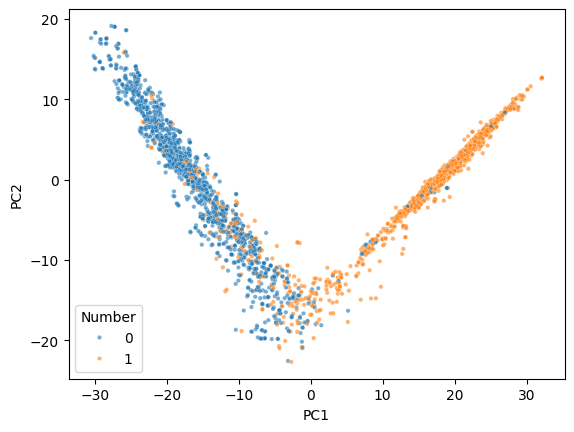

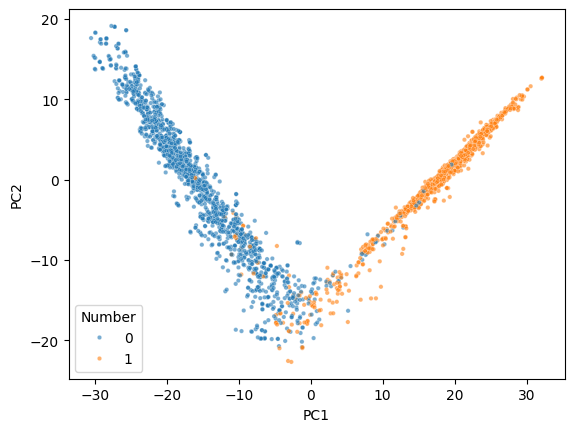

In [19]:
plot_acp(pd.DataFrame(activations_L1_layer1), data_gpt2["targets"])
plot_acp(pd.DataFrame(activations_L1_layer1), data_gpt2["predictions"])
plot_acp(pd.DataFrame(activations_L1_layer2), data_gpt2["targets"])
plot_acp(pd.DataFrame(activations_L1_layer2), data_gpt2["predictions"])

# Attention layers
## Preprocesing

In [ ]:
attentions_gpt2 = unpack_attentions(data_gpt2["attentions"])

In [30]:
max = 0
for obs in attentions_gpt2:
    temp = obs[0].shape[1]
    if temp > max:
        max = temp
print(max)

33


In [32]:
attentions_gpt2[1][0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.6843, 0.3157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4663, 0.4355, 0.0981, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5464, 0.2346, 0.1079, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3840, 0.2143, 0.1145, 0.2421, 0.0450, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1098, 0.1635, 0.0622, 0.5062, 0.0671, 0.0912, 0.0000, 0.0000, 0.0000,
         0.0000, 0.

## Normal model

In [28]:
attentions_gpt2[1][0].shape

torch.Size([12, 19, 19])